# Assignment 2 - Basic Machine Learning to predict Pokémon battles results

([From Wikipedia](https://en.wikipedia.org/wiki/Pok%C3%A9mon)) *Pokémon is a Japanese media franchise managed by The Pokémon Company, a company founded by Nintendo, Game Freak, and Creatures. The franchise was created by Satoshi Tajiri in 1996,[4] and is centered on fictional creatures called "Pokémon". In Pokémon, humans, known as Pokémon Trainers, catch and train Pokémon to battle other Pokémon for sport.*

In this assignment we present you a dataset with the results of several Pokémon battles.

Your objective will be to produce a ML model that can predict the outcomes of any Pokémon battle.

At first, in this notebook, you will apply some of the basic ML approaches that we have seen in class. At this point you can also work with the *small* versions of the dataset if you want.

Later, on the `pokemon-competition.ipynb` notebook, you will train a model using all the data that will be used to predict *real* Pokémon battles.

**Dataset Description**

Within the `datasets.zip` file that you can download from the virtual campus, you will find the following datasets:

- data.train -> Full data available to train the models
- data_inverse.train -> Same data as data.train but each combat is seen from the other player's perspective (i.e. pokemon1 becomes pokemon2 and viceversa)
- small.train -> Subsample of data.train to allow fast prototyping
- small_inverse.train -> Subsample of data_inverse.train to allow fast prototyping
- data.hidden -> Dataset with no label available
- data_inverse.hidden -> Same as data.hidden but the pokemons are inverted

The datasets *.hidden are the ones used to get the tournament score,
so the true label is unknown. All the other datasets are available to
you to use however you want.

*Gotta Train 'Em All!*

In [1]:
from pathlib import Path
import pandas

__wd__ = Path("__file__").resolve().parent
datasets_path = __wd__ / "datasets"

data = pandas.read_csv(datasets_path / "data.train", index_col=0)
inverse_data = pandas.read_csv(datasets_path / "data_inverse.train", index_col=0)

def get_Xy(dataset):
    return dataset.drop("Wins", axis=1), dataset["Wins"]

X, y = get_Xy(data)

In [2]:
# Add your imports here
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Training models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Grid Search
from sklearn.model_selection import GridSearchCV

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder



import warnings
warnings.filterwarnings('ignore')


## Part 1 - Analyze the dataset (2 points)
The first step of any ML process is to know the data we are dealing with. In this part, you have to analyze the dataset and answer the questions below.

1. Which features are categorical? Which are continuous?

In [3]:
# Your code here...
data

categ_features=pd.DataFrame(X,columns=["Type 1","Type 2", "Generation", "Legendary","Type 1__other","Type 2__other","Generation__other","Legendary__other"])
categ_features.astype('category').dtypes
print("Categorical Features: ")
categ_features.head()
data.head()


Categorical Features: 


,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Generation__other,Legendary__other,Wins
39087,Karrablast,Bug,NaN,50.0,72.0,39.0,39.0,42.0,55.0,5.0,...,NaN,50.0,53.0,43.0,47.0,27.0,40.0,5.0,False,True
30893,NaN,Rock,Water,70.0,NaN,125.0,113.0,78.0,NaN,1.0,...,NaN,65.0,64.0,NaN,49.0,41.0,39.0,5.0,False,True
45278,Mega Manectric,Electric,NaN,70.0,77.0,81.0,NaN,91.0,136.0,3.0,...,NaN,NaN,48.0,78.0,NaN,83.0,75.0,5.0,False,True
16398,Bouffalant,Psychic,NaN,95.0,121.0,NaN,39.0,85.0,NaN,5.0,...,NaN,75.0,108.0,101.0,39.0,68.0,106.0,NaN,False,False
13653,Swablu,Normal,Flying,45.0,36.0,58.0,37.0,76.0,56.0,3.0,...,Fairy,40.0,46.0,68.0,108.0,123.0,86.0,1.0,False,False


In [4]:

print("Continuous Features: ")
continuous_features=pd.DataFrame(X,columns=["HP","Attack", "Defense", "Sp. Atk","Sp. Def", "Speed","HP__other", "Attack__other","Defense__other", "Sp. Atk__other", "Sp. Def__other", "Speed__other"])
continuous_features.head()

Continuous Features: 


,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other
39087,50.0,72.0,39.0,39.0,42.0,55.0,50.0,53.0,43.0,47.0,27.0,40.0
30893,70.0,NaN,125.0,113.0,78.0,NaN,65.0,64.0,NaN,49.0,41.0,39.0
45278,70.0,77.0,81.0,NaN,91.0,136.0,NaN,48.0,78.0,NaN,83.0,75.0
16398,95.0,121.0,NaN,39.0,85.0,NaN,75.0,108.0,101.0,39.0,68.0,106.0
13653,45.0,36.0,58.0,37.0,76.0,56.0,40.0,46.0,68.0,108.0,123.0,86.0


2. Observe the distribution of the "Type 1" variable. Use a plot to show this distribution.

<AxesSubplot:>

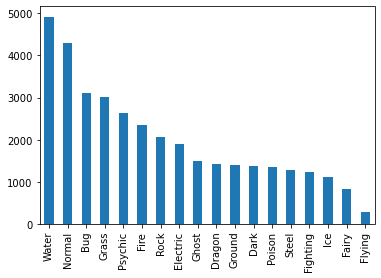

In [5]:
# Your code here...
column = X['Type 1']

column.value_counts().plot.bar()

3. Determine which of the features have missing values. How many missing values there are for each one?

In [6]:
# Your code here...
X.isna().sum()

Name                  3994
Type 1                3974
Type 2               20535
HP                    4006
Attack                3897
Defense               4034
Sp. Atk               3920
Sp. Def               3982
Speed                 3972
Generation            3993
Legendary             3981
Name__other           3963
Type 1__other         4010
Type 2__other        20594
HP__other             4105
Attack__other         3995
Defense__other        4016
Sp. Atk__other        4096
Sp. Def__other        4005
Speed__other          4044
Generation__other     3986
Legendary__other      3982
dtype: int64

4. Analize the distribution of the target column. Is it balanced?

In [7]:
# Your code here...
print("Number of true target columns:")
number_true= (data["Wins"]==True).sum()
print(number_true)

print("Number of false target columns:")
number_false= (data["Wins"]==False).sum()
print(number_false)

true= number_true/ (number_true+number_false) *100
false= number_false/ (number_true+number_false) *100
print("percentage of true values:",true,"%")
print("percentage of false values:",false,"%") 

Number of true target columns:
18848
Number of false target columns:
21152
percentage of true values: 47.12 %
percentage of false values: 52.88 %


## Part 2 - Preprocess the data (3 points)
Once we know how the dataset is, we can proceed with the cleaning of the data. This includes:

- Select the features that you want to use (p.e. removing too specific features). Explain why each feature is used or discarded.
- Impute the missing values. Explain why you use this imputer and not another one. If you use different imputers for different features, explain the reason why you do this.
- Encode the values of the features to work with the model you choose. This can be either encoding the categorical values, or discretizing continuous values.

### My considerations


The features I removed are: 
- Name, the pokemon's name adds nothing to my analysis;             
- Generation, this features does not determine a stronger pokemon;
- Legendary, this feature would only be useful if we wanted to make an analysis of the winning percentage of legendary pokemon, it is not certain that a legendary pokemon always wins over common pokemon. 

The features I used are:
- Type 1, in Pokemon Games the type is very important because it determines whether that pokemon can use "super effective" moves against its rival;
- Type 2, same consideration as Type 1;
- HP, determines the health of the Pokémon; 
- Attack determines the force on physical moves;
- Defense determines the defence on physical moves;
- Sp. Atk determines the force on special moves;
- Sp. Def determines the defence on special moves;
- Speed, Only determines which pokemon will start first, so I don't consider it such an important feature, but in the end for this dataset is   fundamental for the good result.             

the same considerations are made for opponents


In [8]:
d=X.drop(["Name","Generation","Legendary","Name__other","Generation__other","Legendary__other"],axis=1)
d.isnull().sum(axis=0)


Type 1             3974
Type 2            20535
HP                 4006
Attack             3897
Defense            4034
Sp. Atk            3920
Sp. Def            3982
Speed              3972
Type 1__other      4010
Type 2__other     20594
HP__other          4105
Attack__other      3995
Defense__other     4016
Sp. Atk__other     4096
Sp. Def__other     4005
Speed__other       4044
dtype: int64

In [9]:
#populating the continuous empty value with the average
for col in d.columns:
    if d[col].dtypes != object:
        d[col]=d[col].fillna(d[col].mean())

In [10]:
#checking
d.isnull().sum(axis=0)

Type 1             3974
Type 2            20535
HP                    0
Attack                0
Defense               0
Sp. Atk               0
Sp. Def               0
Speed                 0
Type 1__other      4010
Type 2__other     20594
HP__other             0
Attack__other         0
Defense__other        0
Sp. Atk__other        0
Sp. Def__other        0
Speed__other          0
dtype: int64

In [12]:
d.head(20)

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type 1__other,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other
39087,Bug,NaN,50.000000,72.000000,39.000000,39.000000,42.000000,55.000000,Normal,NaN,50.000000,53.000000,43.000000,47.000000,27.000000,40.0
30893,Rock,Water,70.000000,79.254023,125.000000,113.000000,78.000000,68.790441,Fire,NaN,65.000000,64.000000,74.787961,49.000000,41.000000,39.0
45278,Electric,NaN,70.000000,77.000000,81.000000,73.425139,91.000000,136.000000,Poison,NaN,69.838418,48.000000,78.000000,73.168951,83.000000,75.0
16398,Psychic,NaN,95.000000,121.000000,74.663933,39.000000,85.000000,68.790441,Normal,NaN,75.000000,108.000000,101.000000,39.000000,68.000000,106.0
13653,Normal,Flying,45.000000,36.000000,58.000000,37.000000,76.000000,56.000000,Psychic,Fairy,40.000000,46.000000,68.000000,108.000000,123.000000,86.0
13748,Water,Fairy,100.000000,57.000000,87.000000,67.000000,80.000000,51.000000,Water,NaN,64.000000,66.000000,67.000000,78.000000,84.000000,50.0
23965,Water,NaN,55.000000,131.000000,118.000000,51.000000,54.000000,58.000000,Fighting,Psychic,60.000000,61.000000,78.000000,63.000000,72.582525,78.0
45552,Rock,Fairy,50.000000,154.000000,109.000000,164.000000,105.000000,106.000000,Water,NaN,90.000000,75.000000,76.000000,84.000000,102.000000,70.0
30219,Grass,NaN,56.000000,54.000000,72.000000,55.000000,50.000000,68.790441,Water,NaN,92.000000,154.000000,86.000000,73.168951,154.000000,81.0
24079,NaN,Water,80.000000,110.000000,74.663933,132.000000,72.465434,74.000000,Fairy,NaN,90.000000,117.000000,79.000000,62.000000,59.000000,44.0


In [12]:
# generate dummies and OHE
d=pd.get_dummies(d)
names= d.columns
# normalization of the continuous values
scaler = MinMaxScaler()
scaled_d=scaler.fit_transform(d[["HP","Attack", "Defense", "Sp. Atk","Sp. Def", "Speed","HP__other", "Attack__other","Defense__other", "Sp. Atk__other", "Sp. Def__other", "Speed__other"]])
d[["HP","Attack", "Defense", "Sp. Atk","Sp. Def", "Speed","HP__other", "Attack__other","Defense__other", "Sp. Atk__other", "Sp. Def__other", "Speed__other"]]= scaled_d
d.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,HP__other,Attack__other,Defense__other,Sp. Atk__other,...,Type 2__other_Ghost,Type 2__other_Grass,Type 2__other_Ground,Type 2__other_Ice,Type 2__other_Normal,Type 2__other_Poison,Type 2__other_Psychic,Type 2__other_Rock,Type 2__other_Steel,Type 2__other_Water
39087,0.192913,0.372549,0.186992,0.184080,0.147826,0.305699,0.192913,0.276699,0.201613,0.231884,...,0,0,0,0,0,0,0,0,0,0
30893,0.271654,0.408108,0.536585,0.552239,0.304348,0.377153,0.251969,0.330097,0.329790,0.241546,...,0,0,0,0,0,0,0,0,0,0
45278,0.271654,0.397059,0.357724,0.355349,0.360870,0.725389,0.271017,0.252427,0.342742,0.358304,...,0,0,0,0,0,0,0,0,0,0
16398,0.370079,0.612745,0.331967,0.184080,0.334783,0.377153,0.291339,0.543689,0.435484,0.193237,...,0,0,0,0,0,0,0,0,0,0
13653,0.173228,0.196078,0.264228,0.174129,0.295652,0.310881,0.153543,0.242718,0.302419,0.526570,...,0,0,0,0,0,0,0,0,0,0


## Part 3 - Training your model (3 points)
In this part you have to train a **classifier** model to predict if a Pokemon will win or not a battle against another Pokemon. For this, you should explore at least 3 different classifiers.

You have to train and evaluate those classifiers using cross-validation in order to select the best one. Then, you should also study the results of the model (overfit, underfit, possible bias...).

1. Train (at least) 3 different classifiers
2. Evaluate the 3 classifiers using cross-validation. Select the best model according to this metric.
3. For the selected model: 
   1. Get the accuracy for data not seen during the training process
   2. Plot the confusion matrix
   3. Analize the results of accuracy and the confusion matrix

In [13]:
# Split the dataset for training and test
rs=87
X_train, X_test, y_train, y_test = train_test_split(d, y, test_size=0.2, random_state=rs)

print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)



(40000, 22) (32000, 84) (8000, 84)
(40000,) (32000,) (8000,)


In [14]:
#list of classifiers
classifiers = [
    LogisticRegression(random_state=rs),
    DecisionTreeClassifier(random_state=rs), 
    RandomForestClassifier(n_estimators=10, random_state=rs),
]

#results lists:
clf_name= [] #classifier name
model_results= pd.DataFrame.copy(y_test) #result of the prediction

kfold = StratifiedKFold(n_splits=5) #cross validation part
cv_results= [] #score cv
cv_acc= [] #average accuracy cv, maximization
cv_std= [] #standard deviation cv, minimization

cnfm= [] # confusion matrix
clr= [] #classification report


In [15]:
for clf in classifiers:
    name= clf.__class__.__name__
    clf_name.append(name)

    #fitting e predictions part
    model=clf.fit(X_train,y_train)
    y_pred= model.predict(X_test)
    model_results[name]=y_pred

    #accuracy and log loss
    cv_results.append(cross_val_score(clf,X_train,y_train, scoring="accuracy", cv= kfold))
    acc=round(accuracy_score(y_test,y_pred), 2)
    train_pred = clf.predict_proba(X_test)
    print(f'Accuracy: {acc} \t ---> {name} ')

    #confusion matrix
    cnfm.append(confusion_matrix(y_test,y_pred))
    clr.append(classification_report(y_test,y_pred))

#cross validation results
for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())


Accuracy: 0.82 	 ---> LogisticRegression 
Accuracy: 0.79 	 ---> DecisionTreeClassifier 
Accuracy: 0.83 	 ---> RandomForestClassifier 


Text(0.5, 1.0, 'Cross Validation Scores')

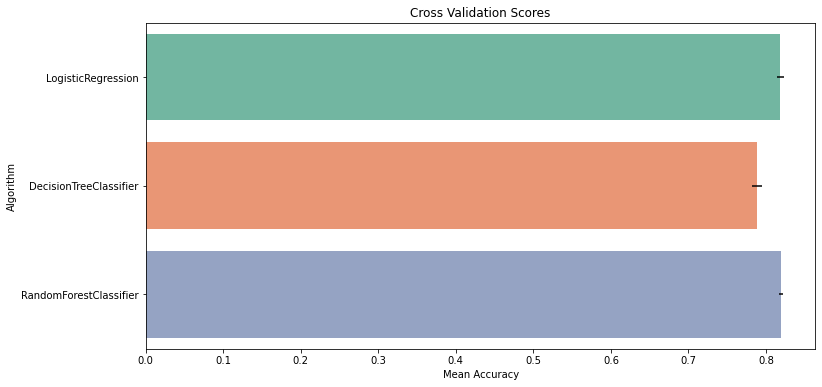

In [16]:

# Cross-Validation Accuracy Results
cv_results= pd.DataFrame({"CrossValMeans":cv_acc,"CrossValerrors":cv_std, "Algorithm":clf_name})

plt.figure(figsize=(12,6))
sns.barplot("CrossValMeans","Algorithm",data=cv_results, palette="Set2",orient="h",**{'xerr':cv_std})
plt.xlabel ("Mean Accuracy")
plt.title("Cross Validation Scores")

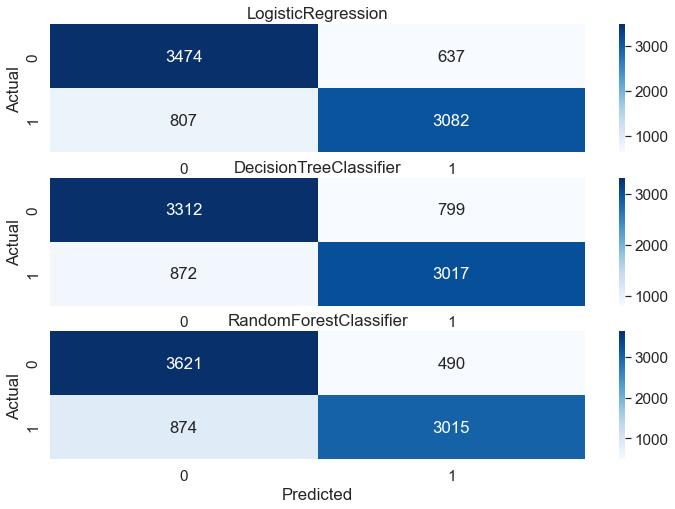

In [17]:
#confusion matrix
plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)
for i in range(len(classifiers)):
    plt.subplot(3,1,i+1)
    sns.heatmap(cnfm[i],annot=True, fmt="d", cmap="Blues")
    plt.title(clf_name[i])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')


In [18]:
#classification report
for i in range(len(classifiers)) :
    print (f"{clf_name[i]} Classification Report:");
    print (clr[i]);

LogisticRegression Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.85      0.83      4111
        True       0.83      0.79      0.81      3889

    accuracy                           0.82      8000
   macro avg       0.82      0.82      0.82      8000
weighted avg       0.82      0.82      0.82      8000

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.81      0.80      4111
        True       0.79      0.78      0.78      3889

    accuracy                           0.79      8000
   macro avg       0.79      0.79      0.79      8000
weighted avg       0.79      0.79      0.79      8000

RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.88      0.84      4111
        True       0.86      0.78      0.82      3889

    accuracy                           0.83     

## Part 4 (Optional) - Create an ensemble and configure the model

You have trained different classifiers but selected only one of them as "the best" one. Maybe instead of having the models competing between them, having them to colaborate would yield better results. 

We propose you to create an ensemble of the different classifiers explored in *Part 3*. You should compare the ensemble with the individual models using cross-validation, and then get the final accuracy and the confusion matrix for the ensemble.
As a bonus, try to tune the parameters of this ensemble using either `GridSearchCV` or `RandomizedSearchCV`.

1. Train an ensemble with the classifiers in *Part 3*.
2. Compare the performance of this ensemble using cross-validation, the final accuracy, and the confusion matrix. Analyze the results.
3. Fine-tune the hyper-parameters of the ensemble using `GridSearchCV` or `RandomizedSearchCV`.

In [20]:
#optimal parameters for decision tree and random forest
LR_param={
    "penalty": ["l1", "l2", None],
    "max_iter": [30,50,100],
    "n_jobs": [1,3,7],
    "C": [0.3,0.7,1.0],
    "fit_intercept": [True]

}

DT_param = {
    "max_depth": [2,3,8,10],
    "max_features": [0.3,0.7,1],
    "min_samples_split": [2,3,10],
    "min_samples_leaf": [1,3,10],
    "criterion": ["gini"]
}
RF_param = {
    "max_depth": [None],
    "max_features": [0.3,0.7,1],
    "min_samples_split": [2,3,10],
    "min_samples_leaf": [1,3,10],
    "bootstrap": [False],
    "n_estimators": [100,300],
    "criterion": ["gini"]
}

LRgs=GridSearchCV(LogisticRegression(), param_grid=LR_param, cv =kfold, n_jobs=4, scoring="accuracy", verbose=True)
DTgs=GridSearchCV(DecisionTreeClassifier(), param_grid=DT_param, cv =kfold, n_jobs=4, scoring="accuracy", verbose=True)
RFgs=GridSearchCV(RandomForestClassifier(), param_grid=RF_param, cv =kfold, n_jobs=4, scoring="accuracy", verbose=True)

models= [LRgs,DTgs,RFgs]

gs_model = []
score= []

for model in models:
    model.fit(X_train,y_train)
    gs_model.append(model.best_estimator_)
    score.append(model.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [21]:
#scores without GridSearch
print("score without GridSearchCV: ", round(cv_acc[0], 3), round(cv_acc[1],3),round(cv_acc[2],3))
#scores with GridSearch
print("score with GridSearchCV: ",round(score[0],3),round(score[1],3), round(score[2],3))

score without GridSearchCV:  0.818 0.788 0.82
score with GridSearchCV:  0.818 0.832 0.854


In [63]:
print("The Best classifier is: ", gs_model[score.index(max(score))])
print("And the score is: ", round(max(score),3))

The Best classifier is:  RandomForestClassifier(bootstrap=False, max_features=0.3, min_samples_split=3,
                       n_estimators=300)
And the score is:  0.854


## Part 5 - Wrap-up (2 points)
The final part of this assignment is to wrap-up your classifier into a pipeline. This pipeline will execute the entire process:

- Preprocess the data
    - Select features
    - Impute data
    - Encode values
- The classifier selected in *Part 3* (or the ensemble if it is better)

This pipeline will be used in the other provided notebook to generate the predictions for the combats you have to submit.

To ensure everything works as expected, we recommend you to load the dataset again before using it with the pipeline. You should also compare the accuracy and the confusion matrix from the pipeline with the model trained before. **Remember to set the random state to all the required transformers and estimators to have a constant output**.

In [87]:
__wd__ = Path("__file__").resolve().parent
datasets_path = __wd__ / "datasets"

data = pandas.read_csv(datasets_path / "data.train", index_col=0)
inverse_data = pandas.read_csv(datasets_path / "data_inverse.train", index_col=0)

def get_Xy(dataset):
    return dataset.drop("Wins", axis=1), dataset["Wins"]

X, y = get_Xy(data)

In [88]:
X=X.drop(["Name","Generation","Legendary","Name__other","Generation__other","Legendary__other"],axis=1)
X

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type 1__other,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other
39087,Bug,NaN,50.0,72.0,39.0,39.0,42.0,55.0,Normal,NaN,50.0,53.0,43.0,47.0,27.0,40.0
30893,Rock,Water,70.0,NaN,125.0,113.0,78.0,NaN,Fire,NaN,65.0,64.0,NaN,49.0,41.0,39.0
45278,Electric,NaN,70.0,77.0,81.0,NaN,91.0,136.0,Poison,NaN,NaN,48.0,78.0,NaN,83.0,75.0
16398,Psychic,NaN,95.0,121.0,NaN,39.0,85.0,NaN,Normal,NaN,75.0,108.0,101.0,39.0,68.0,106.0
13653,Normal,Flying,45.0,36.0,58.0,37.0,76.0,56.0,Psychic,Fairy,40.0,46.0,68.0,108.0,123.0,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,Grass,Fairy,60.0,63.0,122.0,79.0,103.0,118.0,Water,NaN,55.0,NaN,107.0,NaN,79.0,56.0
44732,Poison,Water,50.0,63.0,56.0,54.0,54.0,36.0,Normal,NaN,65.0,59.0,70.0,79.0,79.0,33.0
38158,Fairy,NaN,78.0,58.0,65.0,109.0,NaN,75.0,Normal,NaN,104.0,91.0,61.0,97.0,117.0,68.0
860,Electric,NaN,NaN,43.0,67.0,55.0,92.0,97.0,Electric,Dragon,50.0,70.0,101.0,112.0,97.0,83.0


In [66]:
# Split the dataset for training and test
rs=87
X_train, X_test, y_train, y_test = train_test_split(d, y, test_size=0.2, random_state=rs)

print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(40000, 16) (32000, 84) (8000, 84)
(40000,) (32000,) (8000,)


In [ ]:
y_train.head()

In [67]:
num = ["HP","Attack", "Defense", "Sp. Atk","Sp. Def", "Speed","HP__other", "Attack__other","Defense__other", "Sp. Atk__other", "Sp. Def__other", "Speed__other" ]
cat = ['Type 1_Bug', 'Type 1_Dark', 'Type 1_Dragon',
       'Type 1_Electric', 'Type 1_Fairy', 'Type 1_Fighting', 'Type 1_Fire',
       'Type 1_Flying', 'Type 1_Ghost', 'Type 1_Grass', 'Type 1_Ground',
       'Type 1_Ice', 'Type 1_Normal', 'Type 1_Poison', 'Type 1_Psychic',
       'Type 1_Rock', 'Type 1_Steel', 'Type 1_Water', 'Type 2_Bug',
       'Type 2_Dark', 'Type 2_Dragon', 'Type 2_Electric', 'Type 2_Fairy',
       'Type 2_Fighting', 'Type 2_Fire', 'Type 2_Flying', 'Type 2_Ghost',
       'Type 2_Grass', 'Type 2_Ground', 'Type 2_Ice', 'Type 2_Normal',
       'Type 2_Poison', 'Type 2_Psychic', 'Type 2_Rock', 'Type 2_Steel',
       'Type 2_Water', 'Type 1__other_Bug', 'Type 1__other_Dark',
       'Type 1__other_Dragon', 'Type 1__other_Electric', 'Type 1__other_Fairy',
       'Type 1__other_Fighting', 'Type 1__other_Fire', 'Type 1__other_Flying',
       'Type 1__other_Ghost', 'Type 1__other_Grass', 'Type 1__other_Ground',
       'Type 1__other_Ice', 'Type 1__other_Normal', 'Type 1__other_Poison',
       'Type 1__other_Psychic', 'Type 1__other_Rock', 'Type 1__other_Steel',
       'Type 1__other_Water', 'Type 2__other_Bug', 'Type 2__other_Dark',
       'Type 2__other_Dragon', 'Type 2__other_Electric', 'Type 2__other_Fairy',
       'Type 2__other_Fighting', 'Type 2__other_Fire', 'Type 2__other_Flying',
       'Type 2__other_Ghost', 'Type 2__other_Grass', 'Type 2__other_Ground',
       'Type 2__other_Ice', 'Type 2__other_Normal', 'Type 2__other_Poison',
       'Type 2__other_Psychic', 'Type 2__other_Rock', 'Type 2__other_Steel',
       'Type 2__other_Water']

predictor = Pipeline(
    [
        (
            "preprocessing", ColumnTransformer(
                [
                    (
                        "cat",
                        make_pipeline(
                            SimpleImputer(strategy="most_frequent"),
                            OneHotEncoder(sparse=False, drop="first"),
                        ),
                        cat
                    ),
                    ("num", SimpleImputer(strategy="mean"), num),
                ],
                remainder="drop",
            )
        ),
        ("predictor", RandomForestClassifier(bootstrap=False, max_features=0.3, min_samples_split=3, n_estimators=300)),
    ]
)

In [68]:
model=predictor.fit(X_train, y_train)
y_pred= model.predict(X_test)

In [84]:

acc=round(accuracy_score(y_test,y_pred), 3)
print("Accuracy score:", acc)
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)


Accuracy score: 0.862


Text(44.5, 0.5, 'Actual')

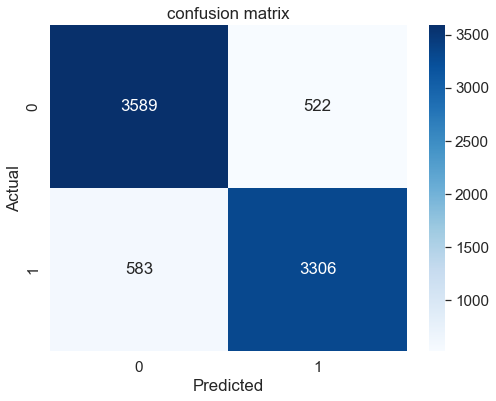

In [85]:
#confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(80.5, 0.5, 'Actual')

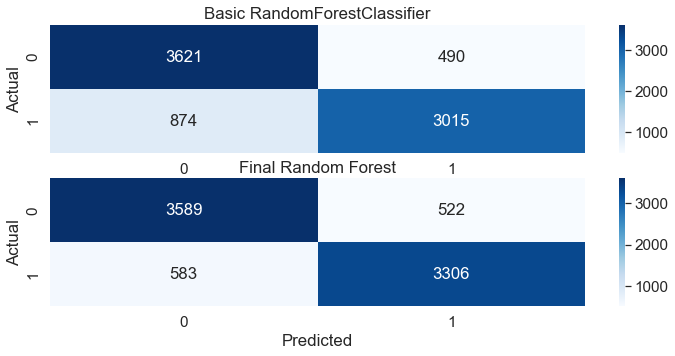

In [86]:
#confusion matrix
plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)
plt.subplot(3,1,1)
sns.heatmap(cnfm[2],annot=True, fmt="d", cmap="Blues")
plt.title("Basic "+clf_name[2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(3,1,2)
sns.heatmap(conf_matrix,annot=True, fmt="d", cmap="Blues")
plt.title("Final Random Forest")
plt.xlabel('Predicted')
plt.ylabel('Actual')
